In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [2]:
# read offense data
offense = pd.read_csv('data/offense.csv')
# read defense data
defense = pd.read_csv('data/defense.csv')
# read salary data
salary = pd.read_csv('data/salary.csv', index_col=0)
# change columns (uppercase first letter) to match the other data
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
# read standings data
standings = pd.read_csv('data/standings.csv')

Need to fix the offense and defense stats so that they are the previous year. Can do this by adding 1 to the year before merging the datasets. Salary is known at the beginning of the season so the year doesn't have to change.

In [3]:
offense['Year'] += 1
defense['Year'] += 1

In [47]:
# merge the offense and defense data with suffixes
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
# merge the salary data
combined = pd.merge(combined, salary, on=['Team', 'Year'])
# merge the standings dataframe - use left so 2018 data stays
combined = pd.merge(combined, standings, on=['Team', 'Year'], how='left')
# now split out the X and y from combined
X = combined[combined.columns[:-8]].copy()
y = combined[combined.columns[-8:]].copy()
y.insert(0, 'Team', X['Team'])
y.insert(1, 'Year', X['Year'])
# add a win percentage column
y['W_Pct'] = y['W'] / 16
display(X.head())
display(y.head())

,Team,Year,Yds/G_rush_off,TD_rush_off,Yds/G_pass_off,Pct_off,TD_pass_off,Sck_off,Rate_off,Pts/G_off,...,WR,nDL,nLB,nOL,nQB,nRB,nS,nST,nTE,nWR
0,WAS,2013,169.3,22.0,213.9,65.8,24.0,33.0,102.1,27.2,...,19610688.0,9.0,13.0,10.0,3.0,5.0,12.0,4.0,4.0,8.0
1,MIN,2013,164.6,16.0,171.9,62.1,18.0,32.0,81.2,23.7,...,9698856.0,10.0,8.0,10.0,4.0,4.0,11.0,3.0,4.0,6.0
2,SEA,2013,161.2,16.0,189.4,64.0,27.0,33.0,100.6,25.8,...,16831421.0,12.0,8.0,10.0,2.0,4.0,12.0,3.0,4.0,7.0
3,SF,2013,155.7,17.0,206.1,66.3,23.0,41.0,101.2,24.8,...,16945181.0,9.0,9.0,10.0,2.0,5.0,11.0,3.0,4.0,7.0
4,KC,2013,149.7,9.0,169.6,57.5,8.0,40.0,63.8,13.2,...,7268150.0,7.0,9.0,12.0,3.0,4.0,10.0,3.0,5.0,6.0


,Team,Year,W,L,T,PF,PA,DIFF,Playoffs,SB_win,W_Pct
0,WAS,2013,3.0,13.0,0.0,334.0,478.0,-144.0,0.0,0.0,0.1875
1,MIN,2013,5.0,10.0,1.0,391.0,480.0,-89.0,0.0,0.0,0.3125
2,SEA,2013,13.0,3.0,0.0,417.0,231.0,186.0,1.0,1.0,0.8125
3,SF,2013,12.0,4.0,0.0,406.0,272.0,134.0,1.0,0.0,0.7500
4,KC,2013,11.0,5.0,0.0,430.0,305.0,125.0,1.0,0.0,0.6875


In [48]:
X.shape

(192, 39)

## Feature Descriptions
**Team** - Team abbreviation (2 or 3 characters)

**Year** - Year of start of season

**Team Stats** (Previous Year)
* **TO** - Turnover differential

**Offensive Stats** (Previous Year)
* **Yds/G_rush_off** - Yards per game rushing by offense
* **TD_rush_off** - Number of rushing touchdowns by offense
* **Yds/G_pass_off** - Yards per game passing by offense
* **Pct_off** - Completion percentage by offense
* **TD_pass_off** - Number of passing touchdowns by offense
* **Sck_off** - Number of sacks allowed by offense
* **Rate_off** - Quarterback rating by offense
* **Pts/G_off** - Points per game by the offense
* **Pen Yds_off** - Penalty yards by offense

**Defensive Stats** (Previous Year)
* **Yds/G_rush_def** - Yards per game rushing allowed by defense
* **TD_rush_def** - Number of rushing touchdowns allowed by defense
* **Yds/G_pass_def** - Yards per game passing allowed by defense
* **TD_pass_def** - Number of passing touchdowns allowed by defense
* **Rate_def** - Quarterback rating allowed by defense
* **Sck_def** - Number of sacks by defense
* **Pct_def** - Completion percentage allowed by defense
* **Pts/G_def** - Points per game allowed by defense
* **Pen Yds_def** - Penalty yards by defense

**Salary Spending by Position** (Current Year)
* **QB** - Quarterback salary
* **RB** - Running back salary
* **WR** - Wide receiver salary
* **TE** - Tight end salary
* **OL** - Offensive line salary
* **DL** - Defensive line salary
* **LB** - Linebacker salary
* **S** - Secondary salary
* **ST** - Special teams salary

**Number of Players per Position** (Current Year)
* **nQB** - Number of quarterbacks
* **nRB** - Number of running backs
* **nWR** - Number of wide receivers
* **nTE** - Number of tight ends
* **nOL** - Number of offensive linemen
* **nDL** - Number of defensive linemen
* **nLB** - Number of linebackers
* **nS** - Number of secondary players
* **nST** - Number of special teams players

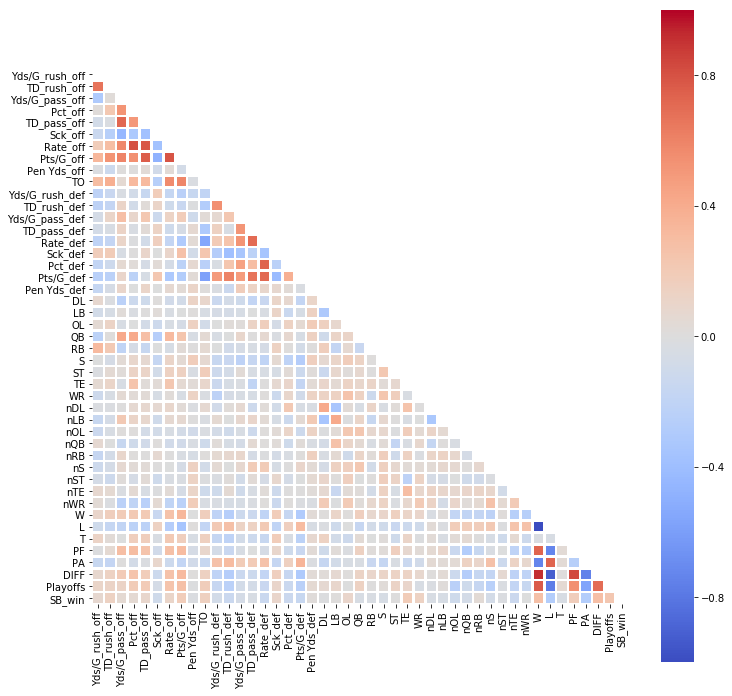

In [49]:
corr = combined[combined.columns[2:]].corr()

import seaborn as sns
from matplotlib.colors import ListedColormap

labels = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
labels = labels.replace(np.nan,' ', regex=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

mask = np.triu(np.ones(corr.shape)).astype(np.bool)

_ = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', square=True, ax=ax)

mask = np.ones(mask.shape)-mask

_ = sns.heatmap(corr, mask=mask, cmap=ListedColormap(['white']),cbar=False, fmt='', 
                linewidths=1.5, ax=ax)

plt.savefig('figures/corr_map.png', dpi=500)

In [71]:
from sklearn.preprocessing import StandardScaler

features = list(X.columns[2:])

target = ['Playoffs']

scaler = StandardScaler()

scaled = combined.copy()

scaled.loc[:, 'Yds/G_rush_off':'nWR'] = scaler.fit_transform(scaled.loc[:, 'Yds/G_rush_off':'nWR'])

#scaled = scaled.loc[:, features + target]

playoff_grp = scaled.groupby('Playoffs').mean()

Check out the highly correlated features

In [131]:
a = combined[combined['Playoffs'] == 0]['Yds/G_rush_off'].values
b = combined[combined['Playoffs'] == 1]['Yds/G_rush_off'].values

In [133]:
from scipy.stats import ttest_ind

t, p = ttest_ind(a, b, equal_var=False)

In [151]:
print('{:^15} {:^8} {:^10}'.format('Variable', 't', 'p-value'))

for col in scaled.columns[2:-8]:
    a = combined[combined['Playoffs'] == 0][col].values
    b = combined[combined['Playoffs'] == 1][col].values
    
    t, p = ttest_ind(a, b, equal_var=False)
    
    print('{:15} {:8.4f} {:10.6f}'.format(col, t, p), end='')
    if p <0.05:
        print('*')
    else:
        print('')

   Variable        t      p-value  
Yds/G_rush_off   -1.3679   0.173847
TD_rush_off      -1.5464   0.124654
Yds/G_pass_off   -1.5043   0.135187
Pct_off          -2.5114   0.013279*
TD_pass_off      -2.4308   0.016794*
Sck_off           0.8573   0.392858
Rate_off         -3.2726   0.001403*
Pts/G_off        -3.4884   0.000703*
Pen Yds_off       0.1320   0.895147
TO               -2.2181   0.028500*
Yds/G_rush_def    2.0906   0.038397*
TD_rush_def       2.9251   0.004098*
Yds/G_pass_def    0.9854   0.326524
TD_pass_def       1.0008   0.318638
Rate_def          1.8813   0.062105
Sck_def          -1.1861   0.237922
Pct_def           1.8031   0.073537
Pts/G_def         3.0900   0.002480*
Pen Yds_def      -0.7460   0.457284
DL               -0.7985   0.426104
LB               -1.1130   0.268160
OL                0.0011   0.999085
QB               -1.8185   0.071185
RB               -0.0186   0.985198
S                -0.3935   0.694544
ST               -1.5257   0.129552
TE               -1.

/Users/tsansom/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


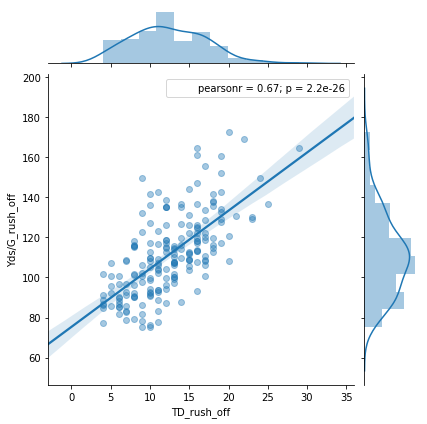

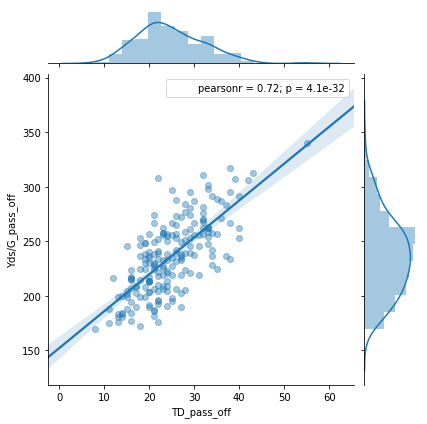

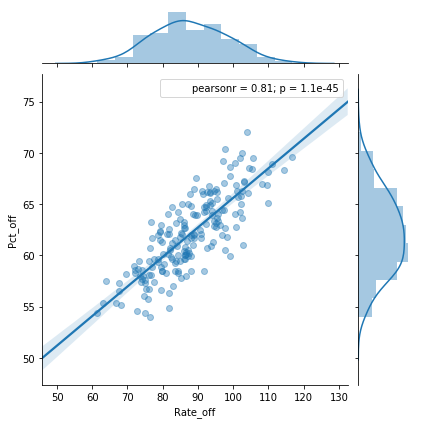

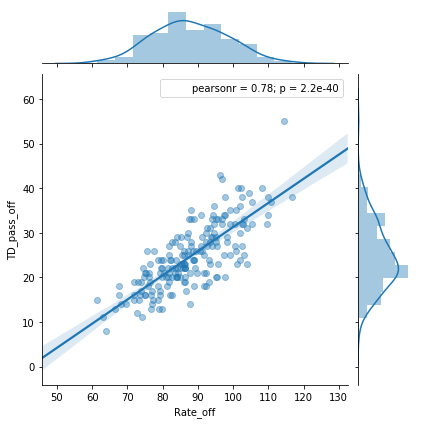

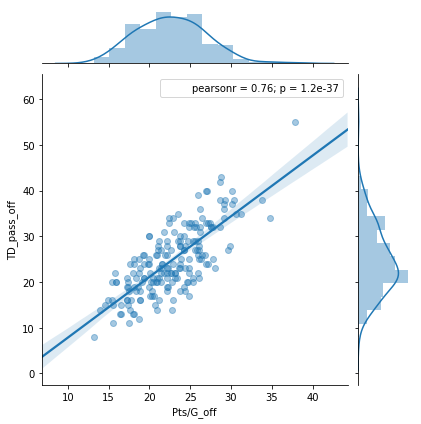

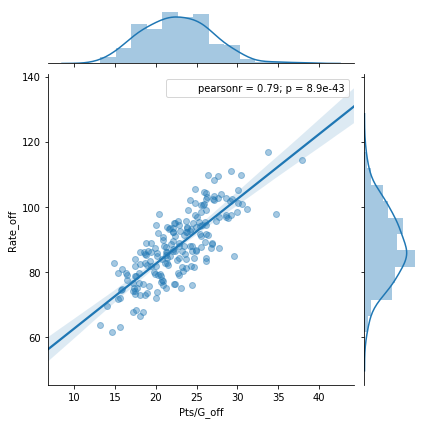

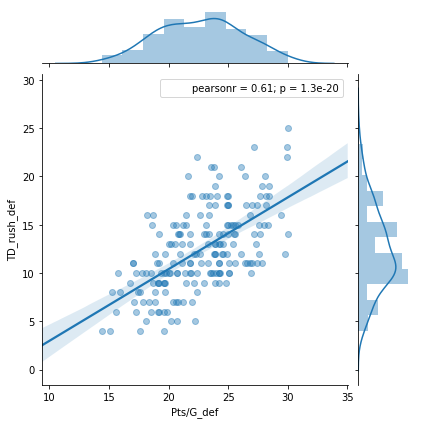

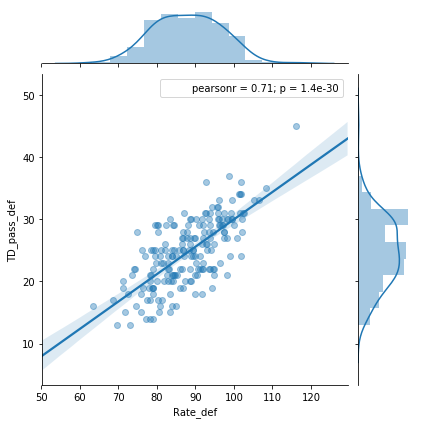

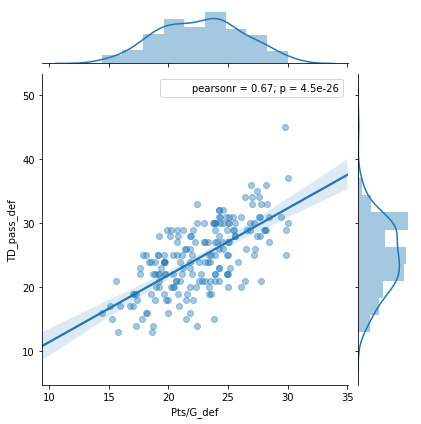

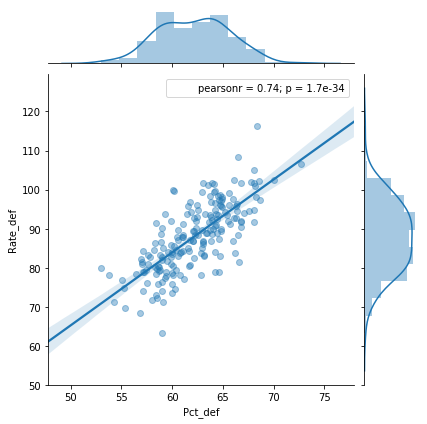

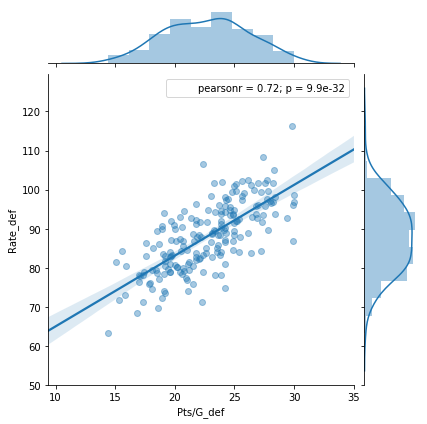

In [13]:
corr = X[X.columns[2:]].corr()

rows = corr.index
cols = corr.columns

ctr = 0

for r in range(len(rows)):
    for c in range(r+1, len(cols)):
        if abs(corr.iloc[r, c]) > 0.6:
            sns.jointplot(data=X, x=cols[c], y=rows[r], kind='reg', scatter_kws={'alpha': 0.4})
            ctr += 1
fig.tight_layout()

